In [2]:
from utils import *
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Reshape, LSTM, TimeDistributed, Permute
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy



Device mapping: no known devices.


In [6]:
X_train, y_train, X_test, y_test = init_data(subject=None, verbose=True)
X_train_aug, y_train_aug, X_test_aug, y_test_aug, X_valid_aug, y_valid_aug= preprocess_data(X_train, y_train, X_test, y_test, verbose=True)
X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug = load_data(X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug, verbose=True)

Training/Valid data shape: (2115, 22, 1000) Training/Valid target shape: (2115,)
Test data shape: (443, 22, 1000) Test target shape: (443,)
Person train/valid shape: (2115, 1) Person test shape: (443, 1)
Training data shape: (7616, 22, 250) Training target shape: (7616,)
Testing data shape: (443, 22, 250) Testing target shape: (443,)
Training data shape: (7616, 250, 1, 22) Training target shape: (7616, 4)
Validation data shape: (844, 250, 1, 22) Validation target shape: (844, 4)
Testing data shape: (443, 250, 1, 22) Testing target shape: (443, 4)


In [7]:
X_train = X_train_aug.reshape(X_train_aug.shape[0], X_train_aug.shape[1], X_train_aug.shape[3])
X_valid = X_valid_aug.reshape(X_valid_aug.shape[0], X_valid_aug.shape[1], X_valid_aug.shape[3])
X_test = X_test_aug.reshape(X_test_aug.shape[0], X_test_aug.shape[1], X_test_aug.shape[3])

In [8]:
epochs = 100

# Define the model
lstm_model = Sequential()

# Adding an LSTM layer
# - units: the dimensionality of the output space
# - input_shape: shape of the input (e.g., (timesteps, features))
lstm_model.add(LSTM(units=22, return_sequences=True, input_shape=(250, 22), dropout=0.5, recurrent_dropout=0.1))
lstm_model.add(BatchNormalization())

lstm_model.add(LSTM(units=22, return_sequences=True, input_shape=(250, 22), dropout=0.5, recurrent_dropout=0.1))
lstm_model.add(BatchNormalization())

# lstm_model.add(LSTM(units=22, return_sequences=True, dropout=0.5, recurrent_dropout=0.1))
# lstm_model.add(BatchNormalization())

lstm_model.add(Flatten())
lstm_model.add(Dropout(0.5))
# lstm_model.add(TimeDistributed(Flatten()))
# lstm_model.add(TimeDistributed(Dense(16, activation='elu')))
lstm_model.add((Dense(4, activation='softmax')))
# lstm_model.add(Reshape((-1,32)))
# lstm_model.add(TimeDistributed(Dense(units=4, activation='softmax')))  # Change the units based on your problem
# lstm_model.add(Flatten())
# # Compile the model
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(from_logits=True),  # Or another appropriate loss function
              metrics=['accuracy'])

# Summary of the model
lstm_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250, 22)           3960      
                                                                 
 batch_normalization (BatchN  (None, 250, 22)          88        
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 250, 22)           3960      
                                                                 
 batch_normalization_1 (Batc  (None, 250, 22)          88        
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 5500)              0         
                                                                 
 dropout (Dropout)           (None, 5500)              0

In [9]:
lstm_model_results = lstm_model.fit(X_train,
                y_train_aug,
                batch_size=256,
                epochs=epochs,
                validation_data=(X_valid, y_valid_aug), verbose=True)

Epoch 1/100


2024-03-15 00:34:42.595844: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 [==============================] - 15s 432ms/step - loss: 2.1165 - accuracy: 0.3059 - val_loss: 1.3611 - val_accuracy: 0.3519
Epoch 2/100
30/30 [==============================] - 12s 410ms/step - loss: 1.7759 - accuracy: 0.3674 - val_loss: 1.2865 - val_accuracy: 0.3910
Epoch 3/100
30/30 [==============================] - 12s 411ms/step - loss: 1.6150 - accuracy: 0.3902 - val_loss: 1.2644 - val_accuracy: 0.4419
Epoch 4/100
30/30 [==============================] - 13s 421ms/step - loss: 1.4932 - accuracy: 0.4116 - val_loss: 1.3233 - val_accuracy: 0.4111
Epoch 5/100
30/30 [==============================] - 13s 421ms/step - loss: 1.4266 - accuracy: 0.4305 - val_loss: 1.3081 - val_accuracy: 0.4218
Epoch 6/100
30/30 [==============================] - 13s 445ms/step - loss: 1.3483 - accuracy: 0.4522 - val_loss: 1.3489 - val_accuracy: 0.4218
Epoch 7/100
30/30 [==============================] - 12s 406ms/step - loss: 1.3060 - accuracy: 0.4652 - val_loss: 1.4103 - val_accuracy: 0.4040
Epoc

### Testing the LSTM model

In [10]:
lstm_score = lstm_model.evaluate(X_test, y_test_aug, verbose=0)
print('Test accuracy of the LSTM model:',lstm_score[1])

Test accuracy of the LSTM model: 0.496614009141922


### Testing on subject 1

In [13]:
X_train_subject, y_train_subject, X_test_subject, y_test_subject = init_data(subject=0, verbose=True)
X_train_aug_subject, y_train_aug_subject, X_test_aug_subject, y_test_aug_subject, X_valid_aug_subject, y_valid_aug_subject= preprocess_data(X_train_subject, y_train_subject, X_test_subject, y_test_subject, verbose=True)
_, _, _, _, X_test_aug_subject, y_test_aug_subject = load_data(X_train_aug_subject, y_train_aug_subject, X_valid_aug_subject, y_valid_aug_subject, X_test_aug_subject, y_test_aug_subject, verbose=True)

X_test_subject = X_test_aug_subject.reshape(X_test_aug_subject.shape[0], X_test_aug_subject.shape[1], X_test_aug_subject.shape[3])

Training Subject 0: Training data shape: (237, 22, 1000) Testing data shape: (237,)
Testing Subject 0: Training data shape: (50, 22, 1000) Testing data shape: (50,)
Training data shape: (856, 22, 250) Training target shape: (856,)
Testing data shape: (50, 22, 250) Testing target shape: (50,)
Training data shape: (856, 250, 1, 22) Training target shape: (856, 4)
Validation data shape: (92, 250, 1, 22) Validation target shape: (92, 4)
Testing data shape: (50, 250, 1, 22) Testing target shape: (50, 4)


In [15]:

lstm_score_subject = lstm_model.evaluate(X_test_subject, y_test_aug_subject, verbose=0)
print('Test accuracy of the LSTM model for subject 0:',lstm_score_subject[1])

Test accuracy of the LSTM model for subject 0: 0.3799999952316284


### Train on different time_stamp

In [7]:
acc_timestamps = []

for i in range(200, 1001, 100):
    X_train, y_train, X_test, y_test = init_data(subject=None, verbose=False)
    X_train_aug, y_train_aug, X_test_aug, y_test_aug, X_valid_aug, y_valid_aug= preprocess_data(X_train, y_train, X_test, y_test, verbose=False, time_stamp=i)
    X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug = load_data(X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug, verbose=True)

    X_train = X_train_aug.reshape(X_train_aug.shape[0], X_train_aug.shape[1], X_train_aug.shape[3])
    X_valid = X_valid_aug.reshape(X_valid_aug.shape[0], X_valid_aug.shape[1], X_valid_aug.shape[3])
    X_test = X_test_aug.reshape(X_test_aug.shape[0], X_test_aug.shape[1], X_test_aug.shape[3])

    epochs = 100

    # Define the model
    lstm_model = Sequential()

    # Adding an LSTM layer
    # - units: the dimensionality of the output space
    # - input_shape: shape of the input (e.g., (timesteps, features))
    lstm_model.add(LSTM(units=22, return_sequences=True, input_shape=(i/2, 22), dropout=0.5, recurrent_dropout=0.1))
    lstm_model.add(BatchNormalization())

    lstm_model.add(LSTM(units=22, return_sequences=True, input_shape=(i/2, 22), dropout=0.5, recurrent_dropout=0.1))
    lstm_model.add(BatchNormalization())

    # lstm_model.add(LSTM(units=22, return_sequences=True, dropout=0.5, recurrent_dropout=0.1))
    # lstm_model.add(BatchNormalization())

    lstm_model.add(Flatten())
    lstm_model.add(Dropout(0.5))
    # lstm_model.add(TimeDistributed(Flatten()))
    # lstm_model.add(TimeDistributed(Dense(16, activation='elu')))
    lstm_model.add((Dense(4, activation='softmax')))
    # lstm_model.add(Reshape((-1,32)))
    # lstm_model.add(TimeDistributed(Dense(units=4, activation='softmax')))  # Change the units based on your problem
    # lstm_model.add(Flatten())
    # # Compile the model
    lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=CategoricalCrossentropy(from_logits=True),  # Or another appropriate loss function
                metrics=['accuracy'])
    
    lstm_model_results = lstm_model.fit(X_train,
                    y_train_aug,
                    batch_size=256,
                    epochs=epochs,
                    validation_data=(X_valid, y_valid_aug), verbose=True)
    
    acc_timestamps.append(lstm_model.evaluate(X_test, y_test_aug, verbose=0)[1])


Training data shape: (7616, 100, 1, 22) Training target shape: (7616, 4)
Validation data shape: (844, 100, 1, 22) Validation target shape: (844, 4)
Testing data shape: (443, 100, 1, 22) Testing target shape: (443, 4)
Epoch 1/100
30/30 [==============================] - 14s 408ms/step - loss: 2.2531 - accuracy: 0.2613 - val_loss: 1.4108 - val_accuracy: 0.2571
Epoch 2/100
30/30 [==============================] - 12s 401ms/step - loss: 1.9665 - accuracy: 0.2874 - val_loss: 1.4110 - val_accuracy: 0.2453
Epoch 3/100
30/30 [==============================] - 12s 402ms/step - loss: 1.8133 - accuracy: 0.2971 - val_loss: 1.4217 - val_accuracy: 0.2405
Epoch 4/100
30/30 [==============================] - 12s 402ms/step - loss: 1.7231 - accuracy: 0.3058 - val_loss: 1.4428 - val_accuracy: 0.2299
Epoch 5/100
30/30 [==============================] - 12s 402ms/step - loss: 1.6327 - accuracy: 0.3220 - val_loss: 1.4362 - val_accuracy: 0.2678
Epoch 6/100
30/30 [==============================] - 12s 402ms/

Text(0, 0.5, 'Accuracy')

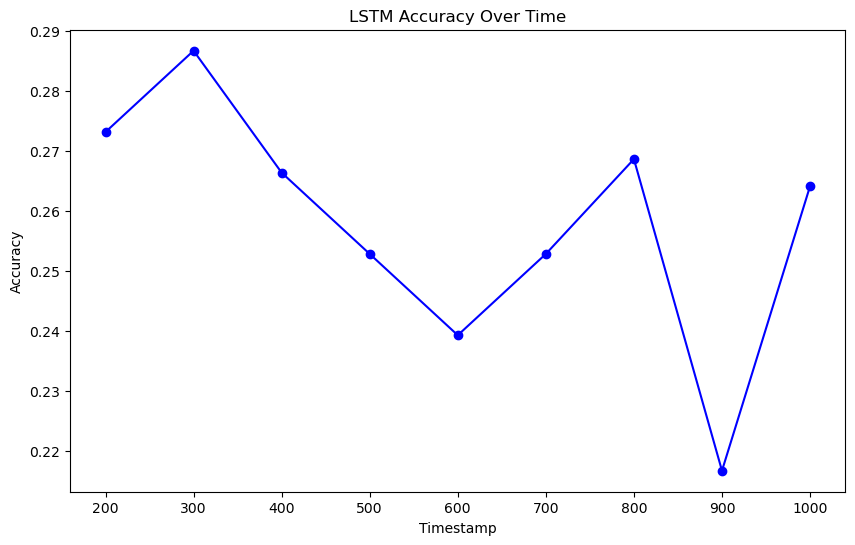

In [8]:
timestamps = [i for i in range(200, 1001, 100)]
plt.figure(figsize=(10, 6))
plt.plot(timestamps, acc_timestamps, marker='o', linestyle='-', color='b')

plt.title('LSTM Accuracy Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Accuracy')

### Train on different subject

In [13]:
acc_subjects = []
acc_subject_v_all = []
X_train, y_train, X_test, y_test = init_data(subject=None, verbose=False)
X_train_aug, y_train_aug, X_test_aug, y_test_aug, X_valid_aug, y_valid_aug= preprocess_data(X_train, y_train, X_test, y_test, verbose=False, time_stamp=300)
_, _, _, _, X_test_aug_all, y_test_aug_all = load_data(X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug, verbose=False)
X_test_aug_all = X_test_aug_all.reshape(X_test_aug_all.shape[0], X_test_aug_all.shape[1], X_test_aug_all.shape[3])


for i in range(9):
    X_train, y_train, X_test, y_test = init_data(subject=i, verbose=False)
    X_train_aug, y_train_aug, X_test_aug, y_test_aug, X_valid_aug, y_valid_aug= preprocess_data(X_train, y_train, X_test, y_test, verbose=False, time_stamp=300)
    X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug = load_data(X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug, verbose=False)

    X_train = X_train_aug.reshape(X_train_aug.shape[0], X_train_aug.shape[1], X_train_aug.shape[3])
    X_valid = X_valid_aug.reshape(X_valid_aug.shape[0], X_valid_aug.shape[1], X_valid_aug.shape[3])
    X_test = X_test_aug.reshape(X_test_aug.shape[0], X_test_aug.shape[1], X_test_aug.shape[3])


    epochs = 100

    # Define the model
    lstm_model = Sequential()

    # Adding an LSTM layer
    # - units: the dimensionality of the output space
    # - input_shape: shape of the input (e.g., (timesteps, features))
    lstm_model.add(LSTM(units=22, return_sequences=True, input_shape=(150, 22), dropout=0.5, recurrent_dropout=0.1))
    lstm_model.add(BatchNormalization())

    lstm_model.add(LSTM(units=22, return_sequences=True, input_shape=(150,22), dropout=0.5, recurrent_dropout=0.1))
    lstm_model.add(BatchNormalization())

    lstm_model.add(Flatten())
    lstm_model.add(Dropout(0.5))
    # lstm_model.add(TimeDistributed(Flatten()))
    # lstm_model.add(TimeDistributed(Dense(16, activation='elu')))
    lstm_model.add((Dense(4, activation='softmax')))
    # lstm_model.add(Reshape((-1,32)))
    # lstm_model.add(TimeDistributed(Dense(units=4, activation='softmax')))  # Change the units based on your problem
    # lstm_model.add(Flatten())
    # # Compile the model
    lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=CategoricalCrossentropy(from_logits=True),  # Or another appropriate loss function
                metrics=['accuracy'])
    
    lstm_model_results = lstm_model.fit(X_train,
                    y_train_aug,
                    batch_size=256,
                    epochs=epochs,
                    validation_data=(X_valid, y_valid_aug), verbose=True)
    
    acc_subjects.append(lstm_model.evaluate(X_test, y_test_aug, verbose=0)[1])
    acc_subject_v_all.append(lstm_model.evaluate(X_test_aug_all, y_test_aug_all, verbose=0)[1])

print('Average accuracy of the LSTM model on all subjects:', sum(acc_subjects)/len(acc_subjects))
print('Average accuracy of the LSTM model on all subjects vs all:', sum(acc_subject_v_all)/len(acc_subject_v_all))

Epoch 1/100


/Users/chris/opt/anaconda3/envs/ece247/lib/python3.10/site-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4/4 [==============================] - 3s 296ms/step - loss: 2.3710 - accuracy: 0.2593 - val_loss: 1.4147 - val_accuracy: 0.2935
Epoch 2/100
4/4 [==============================] - 1s 212ms/step - loss: 1.9844 - accuracy: 0.3353 - val_loss: 1.3791 - val_accuracy: 0.3587
Epoch 3/100
4/4 [==============================] - 1s 226ms/step - loss: 1.8494 - accuracy: 0.3972 - val_loss: 1.3609 - val_accuracy: 0.3913
Epoch 4/100
4/4 [==============================] - 1s 212ms/step - loss: 1.7157 - accuracy: 0.4322 - val_loss: 1.3539 - val_accuracy: 0.3913
Epoch 5/100
4/4 [==============================] - 1s 217ms/step - loss: 1.5467 - accuracy: 0.4393 - val_loss: 1.3491 - val_accuracy: 0.3804
Epoch 6/100
4/4 [==============================] - 1s 213ms/step - loss: 1.4388 - accuracy: 0.4953 - val_loss: 1.3306 - val_accuracy: 0.4022
Epoch 7/100
4/4 [==============================] - 1s 224ms/step - loss: 1.4517 - accuracy: 0.5023 - val_loss: 1.3372 - val_accuracy: 0.4130
Epoch 8/100
4/4 [========

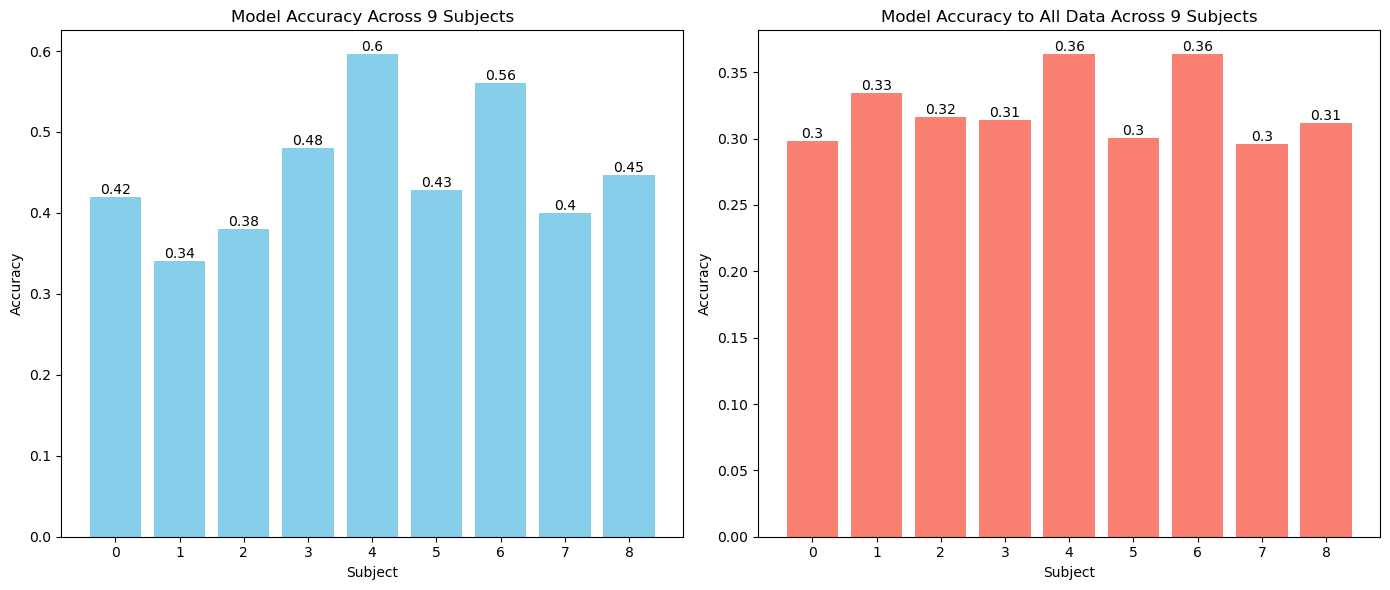

In [14]:
subjects = [i for i in range(9)]


plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1) 
bars = plt.bar(subjects, acc_subjects, color='skyblue')
plt.title('Model Accuracy Across 9 Subjects')
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.xticks(subjects)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.subplot(1, 2, 2) 
bars = plt.bar(subjects, acc_subject_v_all, color='salmon')
plt.title('Model Accuracy to All Data Across 9 Subjects')
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.xticks(subjects)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()